# Modulok és Dataprep

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

In [2]:
working_data = pd.read_excel("C:/Users/Donát/Documents/GitHub/-nkutfel/ONKUTFEL2/NYERS_2021/data_2021_SZŰKJÓ.xlsx")

**Minimális Feature Engineering**

In [3]:
#szűrjük ki a nem kategorikus vagy numerikus változókat
working_data = working_data.drop(labels = ["Name", "Neptun", "Tankör"], axis = 1)

#alakítsuk numerikussá a %-os teljesítménymutatókat
#for i, row in working_data.iterrows():
#    working_data.at[i, "Matek eredmény"] = float(row["Matek eredmény"][:-3] + "." + row["Matek eredmény"][-2])
#    working_data.at[i, "Kognitív eredmény"] = float(row["Kognitív eredmény"][:-3] + "." + row["Kognitív eredmény"][-2])
#    working_data.at[i, "Kognitív pont"] = float(str(row["Kognitív pont"]).replace(",", "."))
#    working_data.at[i, "Össz eredmény (átlag)"] = float(row["Össz eredmény (átlag)"][:-3] + "." + row["Össz eredmény (átlag)"][-2])



In [4]:
#csináljunk a jegyek alapján 3 csoportot: a jó tanulók a 4-5, a rossz a 2-3, a bukás legyen 1
for i, row in working_data.iterrows():
    if working_data.at[i, "Matematika A1a - Analízis"] in [4, 5]:
        working_data.at[i, "Matematika A1a - Analízis"] = 3
    elif working_data.at[i, "Matematika A1a - Analízis"] in [2, 3]:
        working_data.at[i, "Matematika A1a - Analízis"] = 2

In [5]:
working_data['Matematika A1a - Analízis'].value_counts()

2    97
3    54
1    51
Name: Matematika A1a - Analízis, dtype: int64

**Eszközök és szétbontás**

In [6]:
from imblearn.over_sampling import SMOTE



#smote = SMOTE(random_state = 42, k_neighbors = 4, sampling_strategy = {2: 145, 3: 80, 1: 25})

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = working_data.drop(labels = ["Matematika A1a - Analízis", "Szak", "Kognitív pont", "Matek helyes", "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = working_data["Matematika A1a - Analízis"]

#itt nem kell SMOTE
#features, label = smote.fit_resample(features, label)


X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0, stratify=label)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (141). n_quantiles is set to n_samples.
  warnings.warn(


# Osztályozó algoritmusok

**KNN**

In [7]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


Mahalanobis kNN:
{'cv_score': 0.6600985221674878, 'test_score': 0.6557377049180327}
Params:
{'classifier__n_neighbors': 21, 'classifier__weights': 'uniform'}


In [8]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




Euclidian kNN:
{'cv_score': 0.6453201970443351, 'test_score': 0.639344262295082}
Params:
{'classifier__n_neighbors': 27, 'classifier__weights': 'uniform'}


In [9]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 21, 'classifier__weights': 'uniform'} 
- Accuracy: 0.6557377049180327
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 27, 'classifier__weights': 'uniform'} 
- Accuracy: 0.639344262295082


**SVM**

In [10]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')



SVM:
{'cv_score': 0.6458128078817734, 'test_score': 0.6065573770491803}
Params:
{'classifier__C': 1.2000000000000002, 'classifier__kernel': 'rbf'}

Accuracy: 0.61
Precision: 0.61
Recall: 0.61


**Logisztikus Regresszió**

In [11]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


Logistic Regression:
{'cv_score': 0.6172413793103448, 'test_score': 0.6885245901639344}
Params:
{'classifier__C': 3.4000000000000004, 'classifier__solver': 'sag'}

Accuracy: 0.69
Precision: 0.7
Recall: 0.69


**Naive Bayes**

In [12]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.69


In [13]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.6065573770491803 
- Logistic Regression: 0.6885245901639344 
- Naive Bayes: 0.69


**Gradient Boosting**

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

Gradient Boosting:
{'cv_score': 0.630295566502463, 'test_score': 0.7377049180327869}
Params:
{'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.38, 'classifier__max_depth': 3, 'classifier__n_estimators': 30}

Accuracy: 0.74
Precision: 0.74
Recall: 0.74


**Lineáris regresszió**

In [15]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.5911770408008176

In [16]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [ 0.08682634  0.29196511 -0.17363025 -0.64205145 -0.40769279  1.19161811
  0.37998283  0.30829336  0.4544989   0.78921108  0.16522111]
RMSE: 0.46


<function matplotlib.pyplot.show(close=None, block=None)>

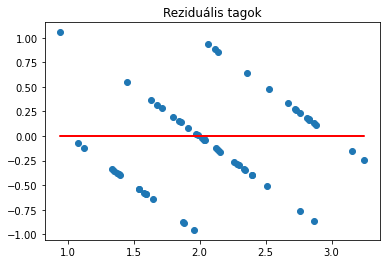

In [17]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [18]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.56

In [19]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.54
0.7


In [20]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.46 
- R2: 0.56 
- RMSE after rounding: 0.54 
- Accuracy after rounding: 0.7


### Eredmények összesítve

In [21]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 21, 'classifier__weights': 'uniform'} 
- Accuracy: 0.6557377049180327
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 27, 'classifier__weights': 'uniform'} 
- Accuracy: 0.639344262295082
SVM:
- Accuracy: 0.6065573770491803
Logistic Regression:
- Accuracy: 0.6885245901639344
Naive Bayes:
- Accuracy: 0.69
Linear regression:
- RMSE: 0.46 
- R2: 0.56 
- RMSE after rounding: 0.54 
- Accuracy after rounding: 0.7


# PCA

In [22]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.52, 0.62, 0.59, 0.64, 0.56, 0.49, 0.62, 0.61, 0.62]

In [23]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.7
Precision: 0.71
Recall: 0.72


In [24]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (141). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (141). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (141). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (141). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total numbe

In [25]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.4754,0.7049,0.6721,0.6885,0.5434,0.2645,0.6529,0.5738
1,2,0.5574,0.7377,0.6557,0.7377,0.5238,0.3497,0.6402,0.5902
2,3,0.6230,0.7213,0.6721,0.7049,0.5219,0.3495,0.6273,0.6066
3,4,0.5082,0.7049,0.6230,0.6885,0.5191,0.3603,0.6140,0.6230
4,5,0.5738,0.6721,0.6066,0.6557,0.5107,0.3713,0.6005,0.6393
5,6,0.6230,0.6885,0.6557,0.6885,0.5054,0.3797,0.6273,0.6066
6,7,0.6721,0.6885,0.6557,0.5738,0.5038,0.3782,0.6005,0.6393
7,8,0.6721,0.7049,0.6557,0.6066,0.4994,0.3753,0.6273,0.6066


In [26]:
working_data = pd.read_excel("C:/Users/Donát/Documents/GitHub/-nkutfel/ONKUTFEL2/NYERS_2021/data_2021_SZŰKJÓ.xlsx")

**Minimális Feature Engineering**

In [27]:
#szűrjük ki a nem kategorikus vagy numerikus változókat
working_data = working_data.drop(labels = ["Name", "Neptun", "Tankör"], axis = 1)

#alakítsuk numerikussá a %-os teljesítménymutatókat
#for i, row in working_data.iterrows():
#    working_data.at[i, "Matek eredmény"] = float(row["Matek eredmény"][:-3] + "." + row["Matek eredmény"][-2])
#    working_data.at[i, "Kognitív eredmény"] = float(row["Kognitív eredmény"][:-3] + "." + row["Kognitív eredmény"][-2])
#    working_data.at[i, "Kognitív pont"] = float(str(row["Kognitív pont"]).replace(",", "."))
#    working_data.at[i, "Össz eredmény (átlag)"] = float(row["Össz eredmény (átlag)"][:-3] + "." + row["Össz eredmény (átlag)"][-2])



In [28]:
#csináljunk a jegyek alapján 3 csoportot: a jó tanulók a 4-5, a rossz a 2-3, a bukás legyen 1
for i, row in working_data.iterrows():
    if working_data.at[i, "Matematika A1a - Analízis"] in [3, 4, 5]:
        working_data.at[i, "Matematika A1a - Analízis"] = 1
    elif working_data.at[i, "Matematika A1a - Analízis"] in [2, 1]:
        working_data.at[i, "Matematika A1a - Analízis"] = 0

In [29]:
working_data['Matematika A1a - Analízis'].value_counts()

0    122
1     80
Name: Matematika A1a - Analízis, dtype: int64

**Eszközök és szétbontás**

In [30]:
from imblearn.over_sampling import SMOTE



#smote = SMOTE(random_state = 42, k_neighbors = 4, sampling_strategy = {2: 145, 3: 80, 1: 25})

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = working_data.drop(labels = ["Matematika A1a - Analízis", "Szak", "Matek helyes","Kognitív pont",  "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = working_data["Matematika A1a - Analízis"]

#itt nem kell SMOTE
#features, label = smote.fit_resample(features, label)


X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0, stratify=label)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (141). n_quantiles is set to n_samples.
  warnings.warn(


# Osztályozó algoritmusok

**KNN**

In [31]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


Mahalanobis kNN:
{'cv_score': 0.8150246305418719, 'test_score': 0.7704918032786885}
Params:
{'classifier__n_neighbors': 18, 'classifier__weights': 'distance'}


In [32]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




Euclidian kNN:
{'cv_score': 0.8578817733990147, 'test_score': 0.7868852459016393}
Params:
{'classifier__n_neighbors': 13, 'classifier__weights': 'distance'}


In [33]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 18, 'classifier__weights': 'distance'} 
- Accuracy: 0.7704918032786885
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 13, 'classifier__weights': 'distance'} 
- Accuracy: 0.7868852459016393


**SVM**

In [34]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')



SVM:
{'cv_score': 0.8435960591133005, 'test_score': 0.7213114754098361}
Params:
{'classifier__C': 0.30000000000000004, 'classifier__kernel': 'linear'}

Accuracy: 0.72
Precision: 0.74
Recall: 0.72


**Logisztikus Regresszió**

In [35]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


Logistic Regression:
{'cv_score': 0.8504926108374384, 'test_score': 0.7377049180327869}
Params:
{'classifier__C': 0.25, 'classifier__solver': 'sag'}

Accuracy: 0.74
Precision: 0.74
Recall: 0.74


**Naive Bayes**

In [36]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.77


In [37]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.7213114754098361 
- Logistic Regression: 0.7377049180327869 
- Naive Bayes: 0.77


**Gradient Boosting**

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

Gradient Boosting:
{'cv_score': 0.8226600985221675, 'test_score': 0.7868852459016393}
Params:
{'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.28, 'classifier__max_depth': 3, 'classifier__n_estimators': 5}

Accuracy: 0.79
Precision: 0.79
Recall: 0.79


**Lineáris regresszió**

In [39]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.502413647379789

In [40]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [-0.06934173  0.22896227  0.21085072 -0.04362892  0.0222181  -0.11813747
 -0.04747897  0.48582632  0.29172077  0.36724242  0.13159775]
RMSE: 0.39


<function matplotlib.pyplot.show(close=None, block=None)>

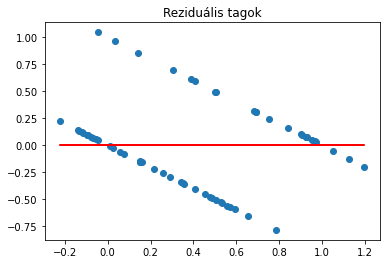

In [41]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [42]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.61

In [43]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.48
0.77


In [44]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.39 
- R2: 0.61 
- RMSE after rounding: 0.48 
- Accuracy after rounding: 0.77


### Eredmények összesítve

In [45]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 18, 'classifier__weights': 'distance'} 
- Accuracy: 0.7704918032786885
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 13, 'classifier__weights': 'distance'} 
- Accuracy: 0.7868852459016393
SVM:
- Accuracy: 0.7213114754098361
Logistic Regression:
- Accuracy: 0.7377049180327869
Naive Bayes:
- Accuracy: 0.77
Linear regression:
- RMSE: 0.39 
- R2: 0.61 
- RMSE after rounding: 0.48 
- Accuracy after rounding: 0.77


# PCA

In [46]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.69, 0.72, 0.69, 0.75, 0.72, 0.77, 0.75, 0.84, 0.8]

In [47]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.79
Precision: 0.79
Recall: 0.79


In [48]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (141). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (141). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (141). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (141). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total numbe

In [49]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.6066,0.7213,0.7377,0.7377,0.4187,0.2791,0.5279,0.7213
1,2,0.7049,0.6885,0.7049,0.7049,0.4221,0.3588,0.5581,0.6885
2,3,0.7049,0.7049,0.7049,0.7541,0.4073,0.3590,0.4959,0.7541
3,4,0.6885,0.7377,0.7869,0.7705,0.3896,0.3970,0.4616,0.7869
4,5,0.7213,0.7377,0.7705,0.7705,0.3921,0.3966,0.4791,0.7705
5,6,0.6885,0.7377,0.8033,0.7869,0.3823,0.4157,0.4791,0.7705
6,7,0.7049,0.7705,0.8525,0.8361,0.3775,0.4197,0.4435,0.8033
7,8,0.6885,0.7541,0.8033,0.8361,0.3810,0.4217,0.4435,0.8033


# Legjobb modellek

In [ ]:
# 3 csoport: Naive Bayes (sima, illetve 6-7 PCA-s), valamint SVM

# 2 csoport: 7-es PCA-s Logreg és Linreg